In [2]:
import pandas as pd
import numpy as np
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 생존여부와는 상관 없을 것 같은 이름, 티켓 번호등의 컬럼을 지워준다.
train.drop(['PassengerId','Name', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Parch'], axis=1, inplace=True) 

# 테스트 데이터 프레임도 마찬가지로 생존여부와는 상관 없을 것 같은 이름, 티켓 번호등의 컬럼을 지워준다.
# 테스트 시 컬럼이 맞아야 예측이 가능하기 때문
test.drop(['PassengerId','Name', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Parch'], axis=1, inplace=True)

# Sex에 있는 문자열 형 데이터 male과 female은 LabelEncoder를 통해 라벨숫자로 변환한다.

from sklearn.preprocessing import LabelEncoder # 라벨링 하기 위해 라벨인코더를 불러와 준다.
Sex_encoder = LabelEncoder() #Sex를 라벨링할 라벨인코더를 정의합니다.
Sex_encoder.fit(train['Sex']) #라벨 인코더에 Sex값들을 넣어줍니다.
train['Sex'] = Sex_encoder.transform(train['Sex']) #인코딩한 값들을 Sex에 넣어줍니다.

#마찬가지로 테스트 데이터 프레임의 Sex컬럼도 encode 시켜준다.
test_Sex_encoder = LabelEncoder()
test_Sex_encoder.fit(test['Sex'])
test['Sex'] = test_Sex_encoder.transform(test['Sex'])

#인코딩이 되었는지 출력해서 확인해 본다.
print(Sex_encoder.classes_)
print(test_Sex_encoder.classes_)
print(train)

['female' 'male']
['female' 'male']
     Survived  Pclass  Sex   Age
0           0       3    1  22.0
1           1       1    0  38.0
2           1       3    0  26.0
3           1       1    0  35.0
4           0       3    1  35.0
..        ...     ...  ...   ...
886         0       2    1  27.0
887         1       1    0  19.0
888         0       3    0   NaN
889         1       1    1  26.0
890         0       3    1  32.0

[891 rows x 4 columns]


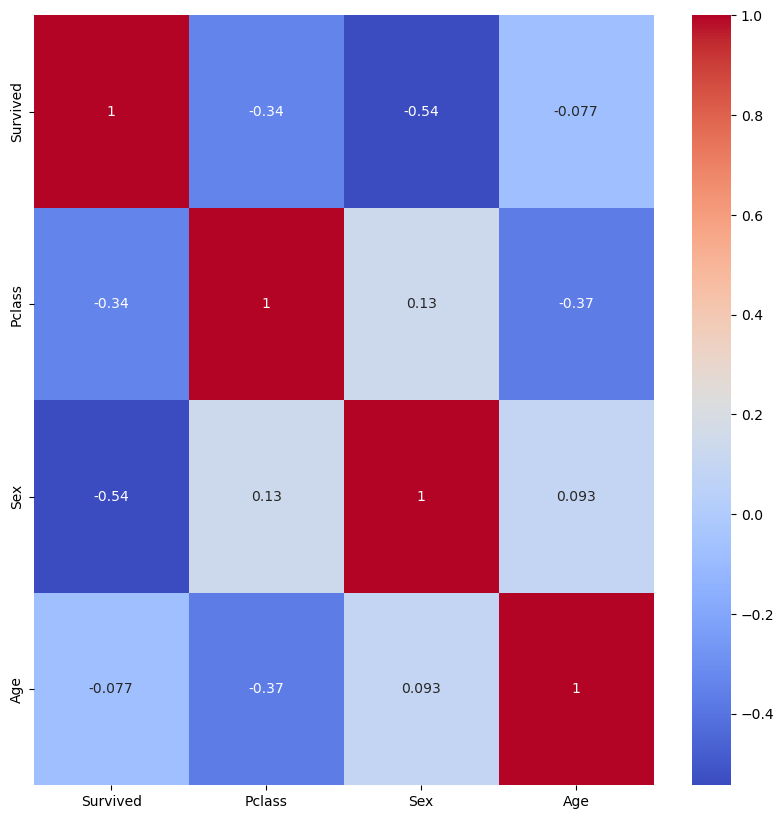

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True)
plt.show()

In [5]:
class1m = train.loc[train.Pclass == 1, 'Age'].mean()
class2m = train.loc[train.Pclass == 2, 'Age'].mean()
class3m = train.loc[train.Pclass == 3, 'Age'].mean()
train.loc[(train.Pclass == 1)&(train.Age.isna()), 'Age'] = class1m
train.loc[(train.Pclass == 2)&(train.Age.isna()), 'Age'] = class2m
train.loc[(train.Pclass == 3)&(train.Age.isna()), 'Age'] = class3m

In [252]:
class1m = test.loc[test.Pclass == 1, 'Age'].mean()
class2m = test.loc[test.Pclass == 2, 'Age'].mean()
class3m = test.loc[test.Pclass == 3, 'Age'].mean()
test.loc[(test.Pclass == 1)&(test.Age.isna()), 'Age'] = class1m
test.loc[(test.Pclass == 2)&(test.Age.isna()), 'Age'] = class2m
test.loc[(test.Pclass == 3)&(test.Age.isna()), 'Age'] = class3m

In [6]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
dtype: int64

In [7]:
# 생존 여부를 예측하는 모델을 만들기 위해 문제와 정답을 나눠 준다. 
# 여기서 답은 생존여부이다.

X = train.drop('Survived', axis=1)
y = train.Survived

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=19)

In [10]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [254]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

In [13]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def xgb_objective(search_space):
    model = XGBClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'loss':hp.choice('loss', ['deviance', 'exponential']),
              'max_depth':hp.choice('max_depth', range(2, 10)),
              'min_samples_split':hp.uniform('min_samples_split', 0.1, 1),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 30)),
              'max_features':hp.choice('max_features', [None, 'sqrt', 'log2']),
              'min_impurity_decrease':hp.uniform('min_impurity_decrease', 0.1, 1),
              'ccp_alpha':hp.uniform('ccp_alpha', 0.01, 1),
              'learning_rate':hp.choice('learning_rate', [0.1, 0.01]),
              'n_estimators':hp.choice('n_estimators', [100, 200, 300, 400, 500,1000])}

# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=xgb_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

[10:49:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease

[10:49:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_f

[10:49:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease

[10:49:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_f

[10:49:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_

[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_

[10:49:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease

[10:49:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_f

[10:49:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease

[10:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_f

[10:49:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:49:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease

[10:50:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_f

[10:50:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_

[10:50:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_

[10:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease

[10:50:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_f

[10:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[10:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_f

In [14]:
params1

{'ccp_alpha': 0.8375820649928876,
 'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.7926798298513817,
 'min_samples_leaf': 8,
 'min_samples_split': 0.9308279224015789,
 'n_estimators': 300}

In [15]:
best_xgb_clf = XGBClassifier(**params1)
best_xgb_clf.fit(X_train, y_train)

[10:50:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              ccp_alpha=0.8375820649928876, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, loss='exponential',
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_features='sqrt', max_leaves=0,
              min_child_weight=1, min_impurity_decrease=0.7926798298513817,
              min_samples_leaf=8, min_samples_split=0.9308279224015789,
              missing=nan, ...)

In [28]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def dt_objective(search_space):
    model = DecisionTreeClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = -accuracy_score(y_test, y_pred)
    return {'loss': accuracy, 'status': STATUS_OK}

# new search space
search_space={'criterion':hp.choice('criterion', ['gini', 'entropy']),
              'max_depth':hp.quniform('max_depth', 3,13,2),
              'max_features':hp.choice('max_features', ['auto', 'sqrt', 'log2']),
              'min_impurity_decrease':hp.quniform('min_impurity_decrease', 0, 1, 0.1),
              'ccp_alpha':hp.quniform('ccp_alpha', 0, 1, 0.1)}


# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=dt_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|██████| 500/500 [00:10<00:00, 49.00trial/s, best loss: -0.8888888888888888]


In [29]:
params1

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 6.0,
 'max_features': 'auto',
 'min_impurity_decrease': 0.0}

In [30]:
best_dt_clf = DecisionTreeClassifier(**params1)
best_dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6.0, max_features='auto')

In [135]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def et_objective(search_space):
    model = ExtraTreesClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = -accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'criterion':hp.choice('criterion', ['gini', 'entropy']),
              'max_depth':hp.choice('max_depth', range(3,15,2)),
              'max_features':hp.choice('max_features', ['auto', 'sqrt', 'log2']),
#               'min_weight_fraction_leaf':hp.quniform('min_weight_fraction_leaf',0,0.5,0.1),
#               'max_leaf_nodes':hp.choice('max_leaf_nodes',[2,3,4,5,6,7,8,9,10]),
#               'min_impurity_decrease':hp.quniform('min_impurity_decrease',0,0.8,0.2),
#               'ccp_alpha':hp.quniform('ccp_alpha', 0, 1, 0.1)
             }


# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=et_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|███████| 500/500 [00:25<00:00, 19.37trial/s, best loss: 0.8111111111111111]


In [66]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def et_objective(search_space):
    model = ExtraTreesClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = -accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'max_depth':hp.quniform('max_depth', 3,15,1),}


# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=et_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|███████| 500/500 [00:27<00:00, 18.21trial/s, best loss: 0.8111111111111111]


In [136]:
params1

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto'}

In [138]:
best_et_clf = ExtraTreesClassifier(**params1)
best_et_clf.fit(X_train, y_train)
# best_et_clf.score(X_test, y_test)

ExtraTreesClassifier(criterion='entropy', max_depth=3)

In [152]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def rf_objective(search_space):
    model = RandomForestClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = -accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'criterion':hp.choice('criterion', ['gini', 'entropy']),
#               'max_depth':hp.choice('max_depth', range(3,15,2)),
              'n_estimators':hp.choice('n_estimators', range(100,1000,100)),
#               'min_samples_split':hp.uniform('min_samples_split', 0.1, 1),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 30)),
              'max_features':hp.choice('max_features', ['auto', 'sqrt', 'log2']),
#               'max_leaf_nodes':hp.choice('max_leaf_nodes',[2,3,4,5,6,7,8,9,10]),
#               'min_impurity_decrease':hp.quniform('min_impurity_decrease',0,0.8,0.2),
#               'ccp_alpha':hp.quniform('ccp_alpha', 0, 1, 0.1)
}


# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=rf_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|███████| 500/500 [02:12<00:00,  3.78trial/s, best loss: 0.8222222222222222]


In [153]:
params1

{'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 23,
 'n_estimators': 100}

In [155]:
best_rf_clf = RandomForestClassifier(**params1)
best_rf_clf.fit(X_train, y_train)
# best_rf_clf.score(X_test, y_test)

RandomForestClassifier(max_features='log2', min_samples_leaf=23)

In [ ]:
best_et_clf = ExtraTreesClassifier(**params1)
best_et_clf.fit(X_train, y_train)


In [188]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def hgb_objective(search_space):
    model = HistGradientBoostingClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = -accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'loss':hp.choice('loss', ['auto', 'binary_crossentropy']),
              'max_depth':hp.choice('max_depth', range(3,15,2)),
#               'learning_rate':hp.quniform('learning_rate', 0.01, 0.1,0.01),
#               'min_samples_leaf':hp.choice('min_samples_leaf', range(10, 30, 2)),
#               'l2_regularization':hp.choice('l2_regularization', [0,0.01,0.1,0.2]),
#               'max_bins':hp.choice('max_bins',[10,100,200,230,255]),
#               'random_state':hp.choice('random_state',range(0,20,2))
             }


# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=hgb_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|███████| 500/500 [00:55<00:00,  8.94trial/s, best loss: 0.8444444444444444]


In [189]:
params1

{'loss': 'binary_crossentropy', 'max_depth': 3}

In [190]:
best_hgb_clf = HistGradientBoostingClassifier(**params1)
best_hgb_clf.fit(X_train, y_train)
# best_hgb_clf.score(X_test, y_test)

HistGradientBoostingClassifier(loss='binary_crossentropy', max_depth=3)

In [242]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import warnings
warnings.filterwarnings('ignore')

def bg_objective(search_space):
    model = BaggingClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = -accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={
    'n_estimators':hp.choice('n_estimators', [10,12]),
#               'max_samples':hp.choice('max_samples', [0.1,0.4,0.7,1.0]),
#               'max_features':hp.choice('max_features', [0.1,0.4,0.7,1.0])
             }


# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=bg_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|██████████████████████| 500/500 [00:05<00:00, 84.80trial/s, best loss: 0.8]


In [243]:
params1

{'n_estimators': 10}

In [244]:
best_bg_clf = BaggingClassifier(**params1)
best_bg_clf.fit(X_train, y_train)
best_bg_clf.score(X_test, y_test)

0.8333333333333334

In [245]:
dt1 = DecisionTreeClassifier(max_depth=6, max_features='auto')
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='auto')
et1 = ExtraTreesClassifier(criterion='entropy', max_depth=3)
et2 = ExtraTreesClassifier(criterion='entropy', max_depth=3, max_features='sqrt')
et3 = ExtraTreesClassifier(max_depth=3)
rf1 = RandomForestClassifier(criterion='entropy', n_estimators=200)
rf2 = RandomForestClassifier(max_depth=3, max_features='sqrt', n_estimators=900)
rf3 = RandomForestClassifier(max_features='log2', min_samples_leaf=23)
hgb1 = HistGradientBoostingClassifier(l2_regularization=0, loss='binary_crossentropy', max_depth=3)
hgb2 = HistGradientBoostingClassifier(max_depth=4)
hgb3 = HistGradientBoostingClassifier(loss='binary_crossentropy', max_depth=6)
bg1 = BaggingClassifier(n_estimators=5)
bg2 = BaggingClassifier(max_samples=0.4, n_estimators=5)
bg3 = BaggingClassifier()
xgb1 = XGBClassifier(ccp_alpha=0.2920700096258636, loss='deviance', max_depth=6,
              max_features='log2', min_impurity_decrease=0.890638952934614,
              min_samples_leaf=1, min_samples_split=0.18701458377327523,
              n_estimators=300)
xgb2 = XGBClassifier(ccp_alpha=0.803240664053215, loss='deviance', max_depth=6,
              max_features='sqrt', min_impurity_decrease=0.5935624381664751,
              min_samples_leaf=29, min_samples_split=0.2754412188138976)
xgb3 = XGBClassifier()

In [257]:
dt1.fit(X,y)
dt1_hat = dt1.predict(test)
result_df = pd.DataFrame({'dt1':dt1_hat})

dt2.fit(X,y)
dt2_hat = dt2.predict(test)
result_df['dt2'] = dt2_hat

et1.fit(X,y)
et1_hat = et1.predict(test)
result_df['et1'] = et1_hat

et2.fit(X,y)
et2_hat = et2.predict(test)
result_df['et2'] = et2_hat

et3.fit(X,y)
et3_hat = et3.predict(test)
result_df['et3'] = et3_hat

rf1.fit(X,y)
rf1_hat = rf1.predict(test)
result_df['rf1'] = rf1_hat

rf2.fit(X,y)
rf2_hat = rf2.predict(test)
result_df['rf2'] = rf2_hat

rf3.fit(X,y)
rf3_hat = rf3.predict(test)
result_df['rf3'] = rf3_hat

hgb1.fit(X,y)
hgb1_hat = hgb1.predict(test)
result_df['hgb1'] = hgb1_hat

hgb2.fit(X,y)
hgb2_hat = hgb2.predict(test)
result_df['hgb2'] = hgb2_hat

hgb3.fit(X,y)
hgb3_hat =hgb3.predict(test)
result_df['hgb3'] = hgb3_hat

bg1.fit(X,y)
bg1_hat = bg1.predict(test)
result_df['bg1'] = bg1_hat

bg2.fit(X,y)
bg2_hat = bg2.predict(test)
result_df['bg2'] = bg2_hat

bg3.fit(X,y)
bg3_hat = bg3.predict(test)
result_df['bg3'] = bg3_hat

xgb1.fit(X,y)
xgb1_hat = xgb1.predict(test)
result_df['xgb1'] = xgb1_hat

xgb2.fit(X,y)
xgb2_hat = xgb2.predict(test)
result_df['xgb2'] = xgb2_hat

xgb3.fit(X,y)
xgb3_hat = xgb3.predict(test)
result_df['xgb3'] = xgb3_hat

[14:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.

[14:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } are not used.



In [258]:
result_df

,dt1,dt2,et1,et2,et3,rf1,rf2,rf3,hgb1,hgb2,hgb3,bg1,bg2,bg3,xgb1,xgb2,xgb3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
414,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


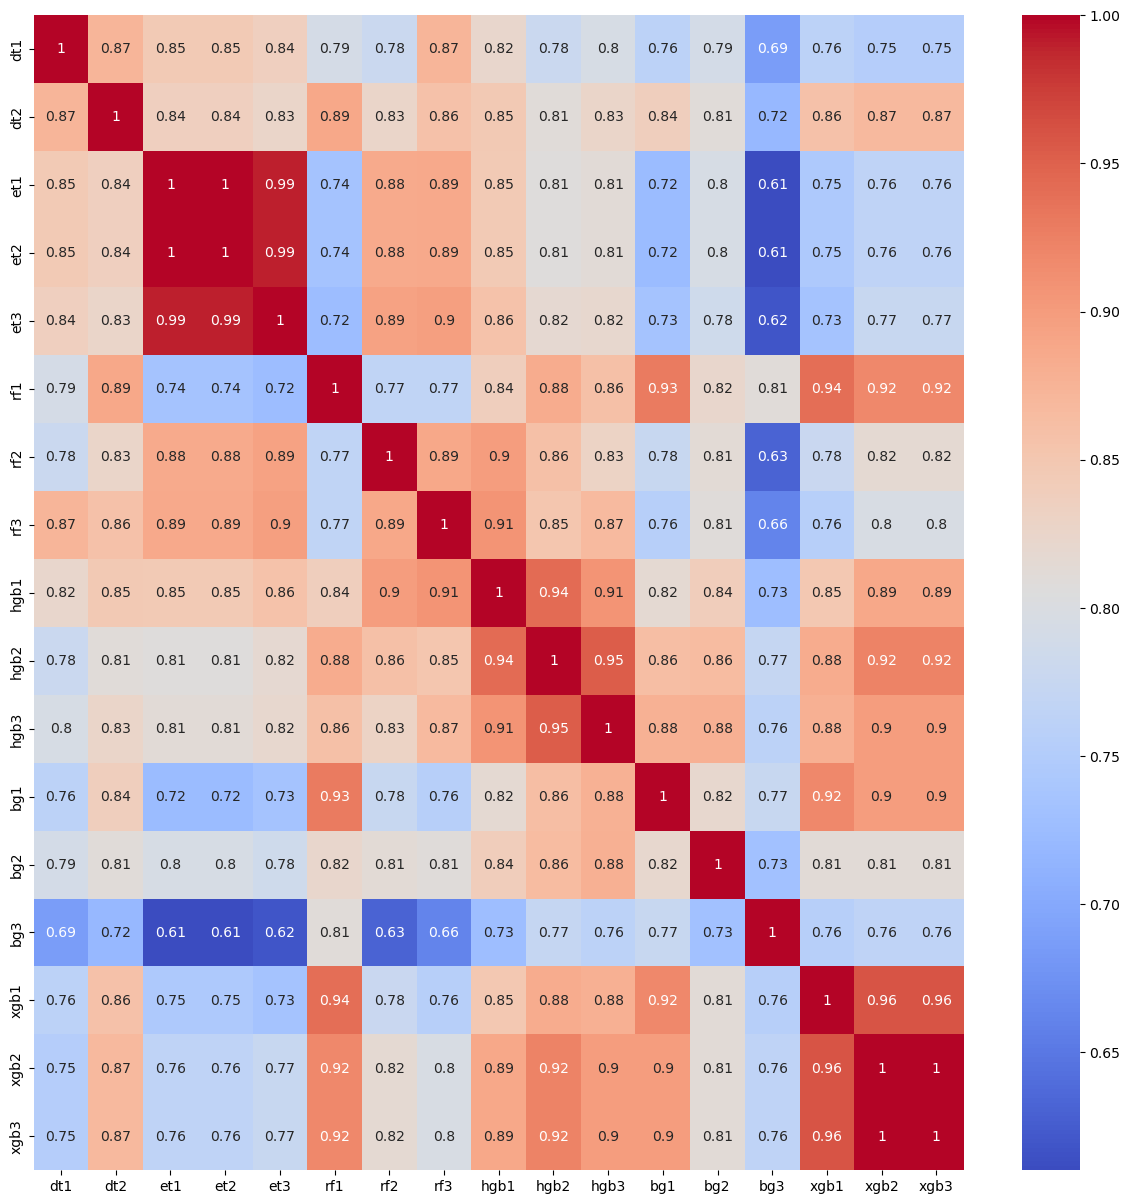

In [263]:
plt.figure(figsize=(15,15))
sns.heatmap(result_df.corr(), cmap='coolwarm', annot=True)
plt.show()